# Predicción Multietiqueta con la base de datos *Planet Amazon*

Traducción al español del la [clase de Fast.ai](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson3-planet.ipynb) por [Fernando Bernuy B.](https://scholar.google.cl/citations?user=Q4tEQYYAAAAJ&hl)

## Antes de empezar...

Para evitar los problemas de la clase anterior, las bases de datos ya fueron descargadas en la máquina y solo es necesario hacer un enlace simbólico (*symlink* / *acceso directo*) de la carpeta con los datos en la ubicación correspondiente. 

Las instrucciones que nos saltaremos en este proceso quedarán comentadas para referencia futura.

In [1]:
!mkdir ~/.fastai
!mkdir ~/.fastai/data
!mkdir ~/.fastai/data/planet
!ln -s /data/home/admin101/.fastai/data/planet/t* ~/.fastai/data/planet/

mkdir: cannot create directory ‘/home/instructor1/.fastai’: File exists
mkdir: cannot create directory ‘/home/instructor1/.fastai/data’: File exists
mkdir: cannot create directory ‘/home/instructor1/.fastai/data/planet’: File exists
ln: failed to create symbolic link '/home/instructor1/.fastai/data/planet/train-jpg': File exists
ln: failed to create symbolic link '/home/instructor1/.fastai/data/planet/train-jpg.tar.7z': File exists
ln: failed to create symbolic link '/home/instructor1/.fastai/data/planet/train_v2.csv': File exists
ln: failed to create symbolic link '/home/instructor1/.fastai/data/planet/train_v2.csv.zip': File exists


### Inicializamos el notebook

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#import torch
#torch.cuda.set_device(3)
from fastai.vision import *

## Obtener la base de datos

La base de datos *Planet Amazon* no está disponible en la [página de bases de datos de fast.ai](https://course.fast.ai/datasets) debido a restricciones de derechos de autor, pero puede ser descargado desde [Kaggle](https://www.kaggle.com). Veamos como hacerlo utilizando la [API de Kaggle](https://github.com/Kaggle/kaggle-api), ya que va a ser muy útil si quieres participar en una competencia o utilizar otra base de datos disponible en Kaggle.

Lo primero es installar la API de Kaggle descomentando y ejecutando la línea siguiente, o ejecutándola en tu terminal (dependiendo de tu plataforma puedes necesitar modificar levemente este comando para, o incluir algo similar a `source activate fastai`, o agregar una ruta específica antes del comando `pip`. Mira como `conda install` es llamado en tu plataforma la sección *Returning to work* de https://course.fast.ai/. Dependiendo de tu entorno de desarrollo, puede necesitar agregar `--user` al comando).

In [4]:
#! {sys.executable} -m pip install kaggle --upgrade

Luego debes subir tus credenciales de Kaggle en tu instancia. Ingresa a tu cuenta de [Kaggle](https://www.kaggle.com), luego entra a la página de tu perfil, y en ella a la sección "My Account". Aquí, busca el botón  llamado "*Create New API Token*" y haz click en él. Esto iniciará la descarga de un archivo llamado "kaggle.json".

Sube este archivo al directorio en el que se está ejecutando este *notebook* haciendo click en "Upload" en la página principal de tu *Jupyter* (o utilizando los comandos para Colab a continuación) y luego ejecuta los comandos de Linux o Windows según corresponda (si estás utilizando Colab, entonces usa los comandos de Linux).

In [5]:
# ---- Para subir archivo en Colab ----
#from google.colab import files
#uploaded = files.upload()

In [6]:
# ---- Para mover en Linux or Colab ----
#! mkdir -p ~/.kaggle/
#! mv kaggle.json ~/.kaggle/

# ---- Para mover en Windows ----
# ! mkdir %userprofile%\.kaggle
# ! move kaggle.json %userprofile%\.kaggle

Ya está todo configurado para descargar los datos de la [competencia planet understanding](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space). **Primero debes ir a su página principal y aceptar sus reglas**, y luego ejecutar las dos celdas siguientes (descomenta los comandos para descargar y descomprimir la data). Si recibes un error `403 forbidden` significa que no has aceptado las reglas de la competencia aún, y debes ir a la página de la competencia, hacer click en el tab *Rules* y hacer click en el boton *accept*.

In [7]:
path = Config.data_path()/'planet'
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/home/instructor1/.fastai/data/planet')

In [8]:
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z -p {path}  
#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  
#! unzip -q -n {path}/train_v2.csv.zip -d {path}

Para extraer el contenido de este archivo, vamos a necesitar *7zip*, asi que descomenta la siguiente line si necesitas instalarlo. (o ejecuta `sudo apt install p7zip-full`).

In [9]:
# ! conda install --yes --prefix {sys.prefix} -c haasad eidl7zip

Y ahora podemos descomprimir la base de datos (descomenta para hacerlo, puede tomar algunos minutos)

In [10]:
#! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

# Clasificación Multietiqueta

Contratrio a la base de datos de mascotas estudiada en la lección anterior, aquí cada imagen puede tener múltiples etiquetas. Si miramos el archivo *csv* que contiene las etiquetas (en `train_v2.csv`) podemos ver que cada `image_name` está asociada a varias etiquetas separadas por espacios:

In [11]:
df = pd.read_csv(path/'train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


Para incluir esto en un `DataBunch` usando la [API de data block](https://docs.fast.ai/data_block.html) necesitamos usar la clase `ImageList` ( y no la clase `ImageDataBunch`). Esto se asegurará que el modelo creado tendrá la función de pérdida apropiada para manejar múltiples etiquetas.

Utilizamos paréntesis entorno al *pipeline* (secuencia de procesos) de *data block* para que podamos hacer una declaración de múltiples líneas sin tener que agregar `\` al final de cada una.

In [12]:
np.random.seed(42)
src = (ImageList.from_csv(path,
                          'train_v2.csv',
                          folder='train-jpg',
                          suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=' '))

In [13]:
# src = ImageList.from_csv(path,'train_v2.csv',folder='train-jpg',suffix='.jpg').split_by_rand_pct(0.2).label_from_df(label_delim=' ')

In [14]:
# src = ImageList.from_csv(path,'train_v2.csv',folder='train-jpg',suffix='.jpg')
# src = src.split_by_rand_pct(0.2)
# src = src.label_from_df(label_delim=' ')

Finalmente agregamos las transformaciones y generamos el databunch.  (ver [get_transforms](https://docs.fast.ai/vision.transform.html#get_transforms) )

In [15]:
tfms = get_transforms(flip_vert=True,
                      max_lighting=0.1,
                      max_zoom=1.05,
                      max_warp=0.)

In [16]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

`show_batch` también funciona en este caso y nos muestra las diferentes etiquetas saparadas por `;`

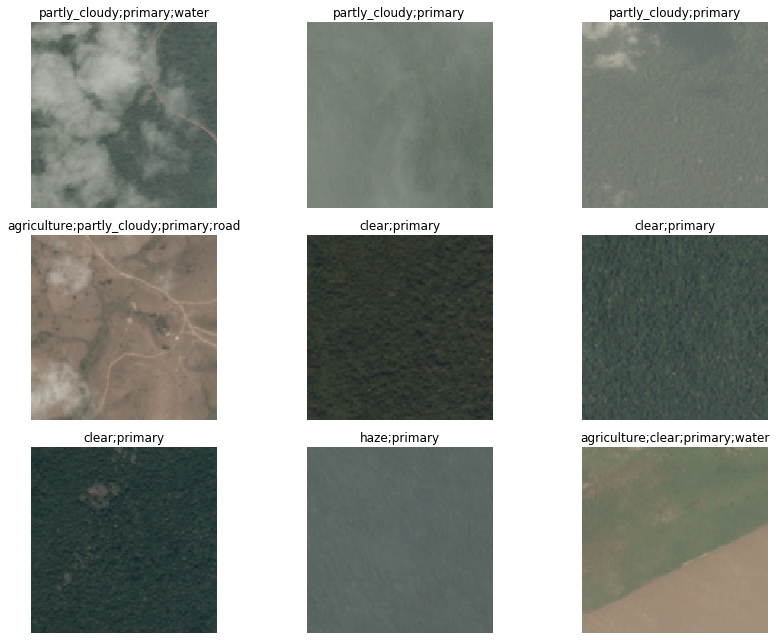

In [17]:
data.show_batch(rows=3, figsize=(12,9))

Para crear un `Learner` utilizamos la misma función de la lección 1, y la arquitectura base también es `resnet50`, pero las métricas son un poco diferentes: utilizamos [`accuracy_thresh`](https://docs.fast.ai/metrics.html#accuracy_thresh) en vez de `accuracy`. En la lección anterior determinamos la predicción de la clase de una imagen al escoger la activación final con el valor más alto, pero aquí cada activación puede estar entre 0 y 1. `accuract_thresh` elige las clases cuya activación sea mayor que un cierto umbral (0.5 por defecto) y las compara con el *ground thruth*.

Finalmente, la competencia de Kaggle utiliza la métrica Fbeta (más detalles [aqui](https://en.wikipedia.org/wiki/F1_score))

In [18]:
arch = models.resnet50

In [19]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

Utilizamos el método `LR Finder` para encontrar el mejor *learning rate*. [¿Por qué?¿Cómo?](https://www.jeremyjordan.me/nn-learning-rate/)

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


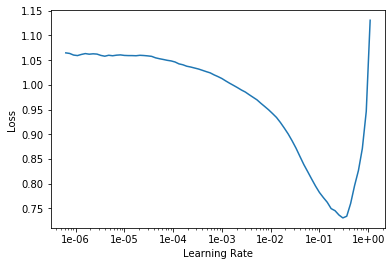

In [21]:
learn.recorder.plot()

Elegimos un *learning rate* apropiado de acuerdo al grafico

In [22]:
lr = 0.01

In [23]:
lr = 0.01
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.137070,0.119845,0.948363,0.894187,02:07
1,0.111924,0.100641,0.949032,0.912463,02:07
2,0.107309,0.093443,0.955390,0.920366,02:08
3,0.097205,0.088710,0.956684,0.923267,05:19
4,0.092445,0.087220,0.956051,0.925518,02:07


In [24]:
learn.save('stage-1-rn50')

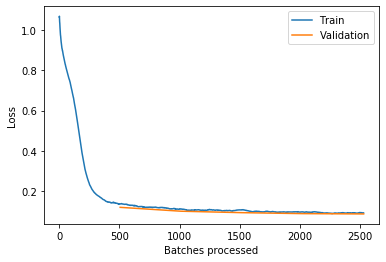

In [25]:
learn.recorder.plot_losses()

... y ahora hacemos *fine-tuning* del modelo completo

In [26]:
learn.unfreeze()

Buscamos el LR adecuado para esta nueva etapa

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


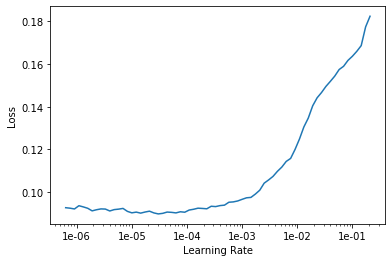

In [27]:
learn.lr_find()
learn.recorder.plot()

nuevamente elegimos un *learning rate* apropiado y volvemos a entrenar

In [28]:
learn.fit_one_cycle(5, slice(2e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.098190,0.092102,0.952280,0.919530,02:47
1,0.097314,0.092426,0.956131,0.921088,02:46
2,0.092254,0.087445,0.955979,0.924735,02:46
3,0.087302,0.083410,0.958384,0.929617,02:46
4,0.082993,0.083088,0.957388,0.928680,02:47


In [29]:
learn.save('stage-2-rn50')

In [30]:
# learn.load('stage-2-rn50')

### Cambio de Tamaño

Un posible método para seguir mejorando el rendimiento de la red es utilizar un tamaño mayor de la imagen de entrada. Para eso cambiaremos la forma del databunch y repetiremos el proceso de entrenamiento: primero las últimas capas y luego la red completa utilizando `lr_find`

In [31]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [32]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


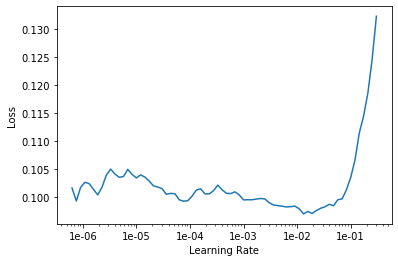

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
lr=1e-2/2

In [35]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.091148,0.086397,0.956247,0.926987,07:53
1,0.087227,0.085997,0.959830,0.926262,07:48
2,0.085622,0.082597,0.958479,0.929310,07:47
3,0.084731,0.081862,0.958871,0.930092,10:57
4,0.080150,0.081261,0.959300,0.930892,07:48


In [36]:
learn.save('stage-1-256-rn50')

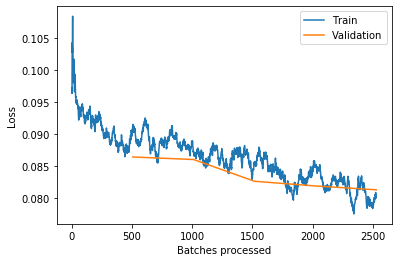

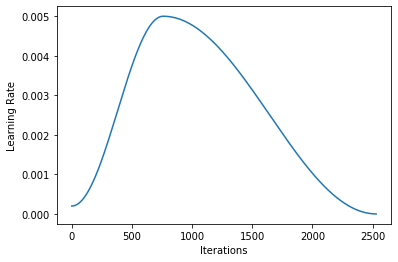

In [37]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()

## Y ahora continuamos con la red completa

In [38]:
learn.unfreeze()

In [39]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.083685,0.084094,0.959220,0.928141,09:47
1,0.085911,0.084072,0.957454,0.927409,09:43
2,0.082082,0.082060,0.958653,0.928721,09:44
3,0.078856,0.080855,0.959917,0.931280,09:46
4,0.074110,0.080523,0.959445,0.930814,09:45


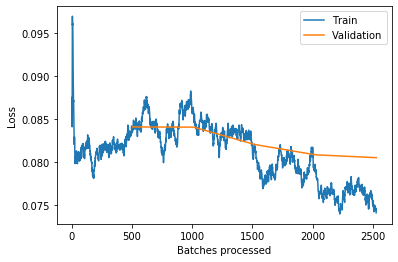

In [40]:
learn.recorder.plot_losses()

In [41]:
learn.save('stage-2-256-rn50')

En la práctica, no podrás saber qué tan bien vas hasta que lo hayas enviado a Kaggle, ya que los resultados se miden con una base e datos distinta a la que tenemos para entrenamiento. A modo de referencia, el lugar 50 (de 938 equipos) en el ranking privado tuvo un puntaje de `0.930`. ([ver leaderboard](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/leaderboard))

In [42]:
learn.export()

# FIN
